## Ref
[Distilling the Knowledge in a Neural Network](http://arxiv.org/abs/1503.02531)

### Setup

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D,GlobalAveragePooling2D,Dense,Softmax,Flatten,MaxPooling2D,Dropout,Activation, Lambda, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import kullback_leibler_divergence as KLD_Loss, categorical_crossentropy as logloss, sparse_categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_accuracy
import seaborn as sns

### Load and preprocess the data

In [2]:
NUM_CLASSES = 10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Normalize the dataset
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train shape: (50000, 32, 32, 3) y_train shape: (50000, 1)


### Create teacher model

In [3]:
Teacher = Sequential() # Must define the input shape in the first layer of the neural network
Teacher.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(32,32,3)))
Teacher.add(MaxPooling2D(pool_size=2))
Teacher.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
Teacher.add(MaxPooling2D(pool_size=2))
Teacher.add(Flatten())
Teacher.add(Dense(256, activation='relu'))
Teacher.add(Dropout(0.5))
Teacher.add(Dense(10))
Teacher.add(Activation('softmax'))

Teacher.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# Take a look at the model summary

Teacher.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1048832   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

In [4]:
myCP = ModelCheckpoint(save_best_only=True, filepath='teacher.h5',monitor = 'val_accuracy')
Teacher.fit(x_train,
         y_train,
         batch_size=128,
         epochs=20,
         validation_split = 0.2,
         callbacks=[myCP])

Epoch 1/20
313/313 [==============================] - 1s 4ms/step - loss: 1.7145 - accuracy: 0.3769 - val_loss: 1.3755 - val_accuracy: 0.5176
Epoch 2/20
313/313 [==============================] - 1s 4ms/step - loss: 1.3876 - accuracy: 0.5020 - val_loss: 1.2331 - val_accuracy: 0.5725
Epoch 3/20
313/313 [==============================] - 1s 4ms/step - loss: 1.2614 - accuracy: 0.5483 - val_loss: 1.1643 - val_accuracy: 0.5924
Epoch 4/20
313/313 [==============================] - 1s 4ms/step - loss: 1.1685 - accuracy: 0.5817 - val_loss: 1.0758 - val_accuracy: 0.6257
Epoch 5/20
313/313 [==============================] - 1s 4ms/step - loss: 1.1125 - accuracy: 0.6014 - val_loss: 1.0395 - val_accuracy: 0.6354
Epoch 6/20
313/313 [==============================] - 1s 4ms/step - loss: 1.0573 - accuracy: 0.6251 - val_loss: 1.0140 - val_accuracy: 0.6463
Epoch 7/20
313/313 [==============================] - 1s 4ms/step - loss: 1.0093 - accuracy: 0.6416 - val_loss: 1.0042 - val_accuracy: 0.6482
Epoch 

In [5]:
# Retrieve best model from saved
Teacher = load_model('teacher.h5')

# Evaluation with test set
Teacher.evaluate(x_test,y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.8660 - accuracy: 0.7023


[0.8659979701042175, 0.7023000121116638]

### Understand temperature

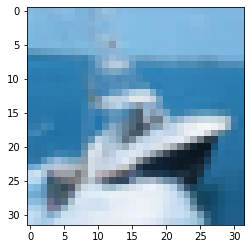

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

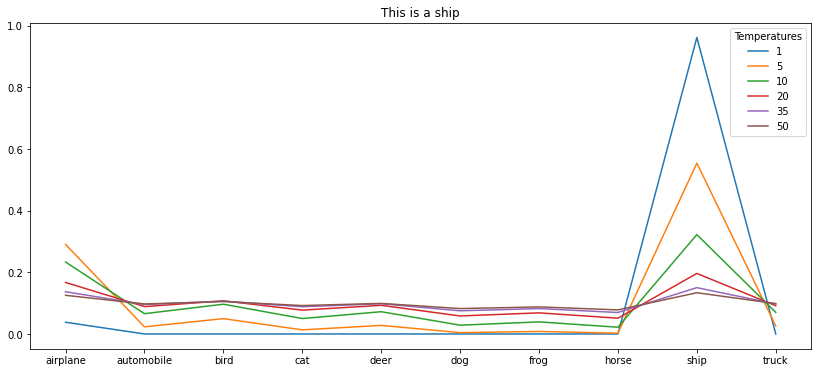

In [6]:
Teacher_logits = Model(Teacher.input,Teacher.layers[-2].output)

logits_plot = []

class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

# Choose the item to visualize temperature
item_idx = 8

item_image = x_train[item_idx]

plt.imshow(item_image)

Temperatures = [1,5,10,20,35,50]


for Temperature in Temperatures:
    # Create temperature layer that produces logits with temperature
    T_layer = Lambda(lambda x:x/Temperature)(Teacher_logits.output)

    # Create a softmax layer
    Softmax_layer = Softmax()(T_layer)
    # Add the teacher T_layer to the whole model
    Teacher_logits_soften = Model(Teacher.input,Softmax_layer)

    # Append for plotting
    logits_plot.append(Teacher_logits_soften.predict(np.array([item_image])))

    plt.figure(figsize=(14, 6))
    
for i in range(len(Temperatures)):
    sns.lineplot(class_names,logits_plot[i][0],legend="full")
    plt.title('This is a '+ class_names[y_train[item_idx][0]])
    plt.legend(Temperatures,title="Temperatures")

In [7]:
Temperature = 3.25
T_layer = Lambda(lambda x:x/Temperature)(Teacher_logits.output)
Softmax_layer = Activation('softmax')(T_layer)
Teacher_soften = Model(Teacher.input,Softmax_layer)

In [8]:
# Predict and convert to sparse categorical matrix
y_train_new = Teacher_soften.predict(x_train)
y_test_new = Teacher_soften.predict(x_test)

y_train_new = np.c_[to_categorical(y_train),y_train_new]
y_test_new = np.c_[to_categorical(y_test),y_test_new]

In [9]:
Student = Sequential() #a Must define the input shape in the first layer of the neural network
Student.add(Flatten(input_shape=(32,32,3)))
Student.add(Dense(64, activation='relu'))
Student.add(Dense(10))
Student.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                196672    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 197,322
Trainable params: 197,322
Non-trainable params: 0
_________________________________________________________________


In [10]:
student_logits = Student.layers[-1].output

# Compute softmax
probs = Activation("softmax", name='probs')(student_logits)

# Compute softmax with softened logits
logits_T = Lambda(lambda x:x/Temperature)(student_logits)
probs_T = Activation("softmax")(logits_T)

CombinedLayers = concatenate([probs,probs_T])

StudentModel = Model(Student.input,CombinedLayers)

StudentEval = Model(Student.input, probs)

In [11]:
def KD_loss(y_true,y_pred,lambd=0.5,T=10.0):
    y_true,y_true_KD = y_true[:,:NUM_CLASSES],y_true[:,NUM_CLASSES:]
    y_pred,y_pred_KD = y_pred[:,:NUM_CLASSES],y_pred[:,NUM_CLASSES:]
    # Classic cross-entropy (without temperature)
    CE_loss = logloss(y_true,y_pred)
    # KL-Divergence loss for softened output (with temperature)
    KL_loss = T**2*KLD_Loss(y_true_KD,y_pred_KD)

    return lambd*CE_loss + (1-lambd)*KL_loss

def accuracy(y_true,y_pred):
    return categorical_accuracy(y_true,y_pred)

In [12]:
StudentModel.compile(optimizer='adam',loss=lambda y_true,y_pred: KD_loss(y_true, y_pred,lambd=0.5,T=Temperature),metrics=[accuracy])


In [13]:
myCP = ModelCheckpoint(save_best_only=True,filepath='student.h5',monitor = 'val_accuracy')

StudentModel.fit(x_train,y_train_new,epochs=50,validation_split=0.15,batch_size=128,callbacks=[myCP])

Epoch 1/50
333/333 [==============================] - 1s 3ms/step - loss: 3.5088 - accuracy: 0.3126 - val_loss: 3.2077 - val_accuracy: 0.3472
Epoch 2/50
333/333 [==============================] - 1s 3ms/step - loss: 3.0613 - accuracy: 0.3749 - val_loss: 2.9671 - val_accuracy: 0.3576
Epoch 3/50
333/333 [==============================] - 1s 3ms/step - loss: 2.9133 - accuracy: 0.3932 - val_loss: 2.7931 - val_accuracy: 0.3912
Epoch 4/50
333/333 [==============================] - 1s 3ms/step - loss: 2.8033 - accuracy: 0.4067 - val_loss: 2.9053 - val_accuracy: 0.3739
Epoch 5/50
333/333 [==============================] - 1s 3ms/step - loss: 2.7370 - accuracy: 0.4115 - val_loss: 2.8031 - val_accuracy: 0.3804
Epoch 6/50
333/333 [==============================] - 1s 3ms/step - loss: 2.6645 - accuracy: 0.4224 - val_loss: 2.6957 - val_accuracy: 0.3903
Epoch 7/50
333/333 [==============================] - 1s 3ms/step - loss: 2.6192 - accuracy: 0.4270 - val_loss: 2.6853 - val_accuracy: 0.3948
Epoch 

In [14]:
StudentModel.load_weights('student.h5')
StudentModel.evaluate(x_train,y_train_new)

1563/1563 [==============================] - 2s 1ms/step - loss: 2.2336 - accuracy: 0.4698


[2.233569622039795, 0.46983999013900757]

### Create a standalone student

In [15]:
AloneModel = Sequential()
AloneModel.add(Flatten(input_shape=(32,32,3)))
AloneModel.add(Dense(64, activation='relu'))
AloneModel.add(Dense(10, activation='softmax'))
AloneModel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                196672    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 197,322
Trainable params: 197,322
Non-trainable params: 0
_________________________________________________________________


In [16]:
AloneModel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
myCP = ModelCheckpoint(best_only=True, filepath='alone.h5', monitor='val_acc')
AloneModel.fit(x_train, y_train, epochs=50, validation_split=0.15, batch_size=128, callbacks=[myCP])

Epoch 1/50
333/333 [==============================] - 1s 2ms/step - loss: 1.9461 - accuracy: 0.2981 - val_loss: 1.8667 - val_accuracy: 0.3271
Epoch 2/50
333/333 [==============================] - 1s 2ms/step - loss: 1.8113 - accuracy: 0.3554 - val_loss: 1.8115 - val_accuracy: 0.3465
Epoch 3/50
333/333 [==============================] - 1s 2ms/step - loss: 1.7634 - accuracy: 0.3767 - val_loss: 1.9717 - val_accuracy: 0.2973
Epoch 4/50
333/333 [==============================] - 1s 2ms/step - loss: 1.7398 - accuracy: 0.3844 - val_loss: 1.7643 - val_accuracy: 0.3785
Epoch 5/50
333/333 [==============================] - 1s 2ms/step - loss: 1.7067 - accuracy: 0.3959 - val_loss: 1.7648 - val_accuracy: 0.3793
Epoch 6/50
333/333 [==============================] - 1s 2ms/step - loss: 1.6893 - accuracy: 0.4020 - val_loss: 1.7494 - val_accuracy: 0.3745
Epoch 7/50
333/333 [==============================] - 1s 3ms/step - loss: 1.6749 - accuracy: 0.4060 - val_loss: 1.7262 - val_accuracy: 0.3841
Epoch 

In [17]:
AloneModel = load_model('alone.h5')
AloneModel.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 1.6210 - accuracy: 0.4317


[1.6209990978240967, 0.4316999912261963]